DATASET OVERVIEW
Samples: 1866
Features: 13
Time steps (records): 13632
Size: 2522.93 MB

FEATURE STATISTICS (across all samples & locations)
 0. Latitude     | min:      18.65 | max:      53.47 | mean:      33.38
 1. Longitude    | min:      75.25 | max:     133.99 | mean:     112.43
 2. Altitude     | min:     -47.20 | max:    4613.00 | mean:     605.86
 3. Air pressure | min:     564.90 | max:    1050.00 | mean:     948.94
 4. Air Temperature | min:     -17.50 | max:      47.20 | mean:      14.42
 5. Maximum Temperature | min:     -16.85 | max:      48.10 | mean:      14.91
 6. Minimum Temperature | min:     -17.75 | max:      46.90 | mean:      13.94
 7. Relative humidity | min:       0.00 | max:     100.00 | mean:      67.57
 8. Precipitation in 3h | min:      -1.00 | max:    1049.70 | mean:       0.34
 9. Wind direction | min:       0.00 | max:     360.00 | mean:     174.47
10. Wind speed   | min:       0.00 | max:      37.70 | mean:       2.08
11. Maximum wind direction | min:  

c:\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python311\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Unique Latitude values: 1234
Unique Longitude values: 1306
Altitude range: -47m to 4613m


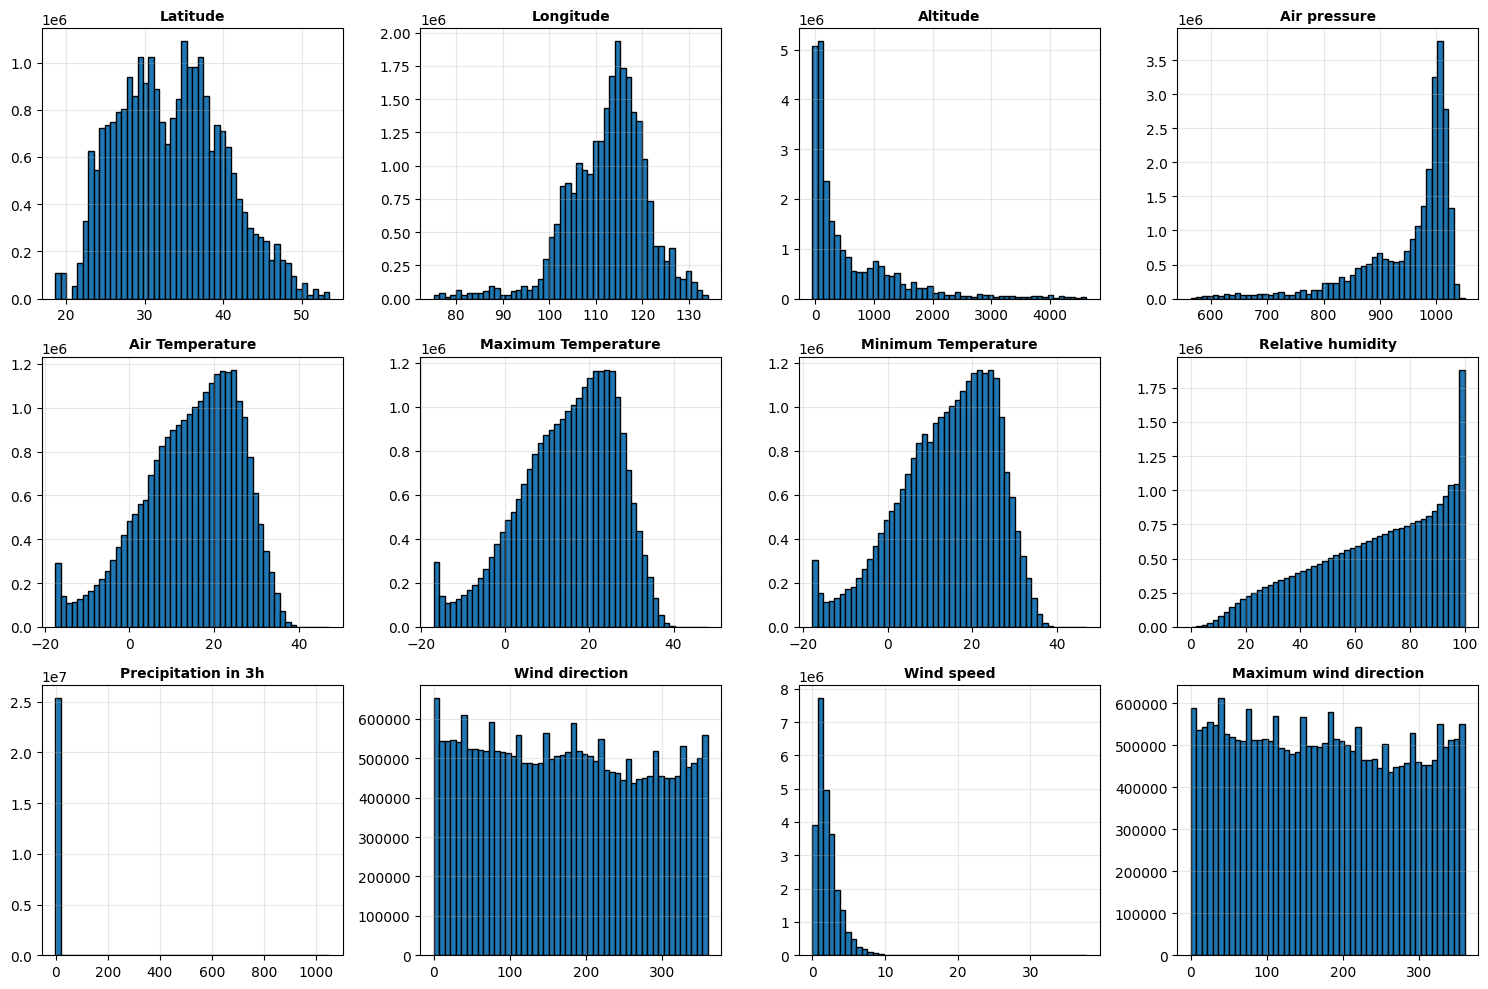

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.load(r"weather2k.npy", allow_pickle=True)

# Feature names
features = ['Latitude', 'Longitude', 'Altitude', 'Air pressure', 'Air Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Relative humidity', 'Precipitation in 3h', 
            'Wind direction', 'Wind speed', 'Maximum wind direction', 'Maximum wind speed']

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Samples: {data.shape[0]}")
print(f"Features: {data.shape[1]}")
print(f"Time steps (records): {data.shape[2]}")
print(f"Size: {data.nbytes / (1024**2):.2f} MB\n")

print("="*60)
print("FEATURE STATISTICS (across all samples & locations)")
print("="*60)
for i, fname in enumerate(features[:data.shape[1]]):
    feature_data = data[:, i, :]
    print(f"{i:2d}. {fname:12s} | min: {feature_data.min():10.2f} | "
          f"max: {feature_data.max():10.2f} | mean: {feature_data.mean():10.2f}")

print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
print(f"NaN values: {np.isnan(data).sum()}")
print(f"Inf values: {np.isinf(data).sum()}")
print(f"Zero values: {(data == 0).sum()} ({(data == 0).sum() / data.size * 100:.2f}%)")

print("\n" + "="*60)
print("SAMPLE ANALYSIS")
print("="*60)
print(f"Sample 0 temp range: {data[0, 4, :].min():.1f}°C to {data[0, 4, :].max():.1f}°C")
print(f"Sample 0 humidity range: {data[0, 7, :].min():.1f}% to {data[0, 7, :].max():.1f}%")

# Visualize feature distributions
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(12, data.shape[1])):
    feature_data = data[:, i, :].flatten()
    axes[i].hist(feature_data[~np.isnan(feature_data)], bins=50, edgecolor='black')
    axes[i].set_title(f"{features[i]}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_features_distribution.png', dpi=100)
print("\n✓ Saved feature distributions to 'weather_features_distribution.png'")

# Correlation analysis
print("\n" + "="*60)
print("FEATURE CORRELATIONS (sample 0)")
print("="*60)
sample_data = data[0, :, :].T  # Transpose to (locations, features)
corr_matrix = np.corrcoef(sample_data.T)

# Show strongest correlations
for i in range(min(5, data.shape[1])):
    for j in range(i+1, min(5, data.shape[1])):
        print(f"{features[i]:6s} vs {features[j]:6s}: {corr_matrix[i, j]:6.3f}")

print("\n" + "="*60)
print("SPATIAL ANALYSIS")
print("="*60)
print(f"Unique Latitude values: {len(np.unique(data[:, 0, :]))}")
print(f"Unique Longitude values: {len(np.unique(data[:, 1, :]))}")
print(f"Altitude range: {data[:, 2, :].min():.0f}m to {data[:, 2, :].max():.0f}m")

In [8]:
# Select feature and sample
FEATURE_INDEX = 4  # Air Temperature
SAMPLE_INDEX = 0

series = data[SAMPLE_INDEX, FEATURE_INDEX, :]

print(f"Selected series shape: {series.shape}")


Selected series shape: (13632,)


In [18]:
# Convert to float
series = series.astype(np.float64)

# Replace inf values with NaN
series[np.isinf(series)] = np.nan


# Handle missing values (linear interpolation)
if np.isnan(series).sum() > 0:
    x = np.arange(len(series))
    series = np.interp(x, x[~np.isnan(series)], series[~np.isnan(series)])

print(f"Remaining NaNs: {np.isnan(series).sum()}")


Remaining NaNs: 0


In [10]:
n = len(series)

train_size = int(n * 0.7)
val_size = int(n * 0.15)

train = series[:train_size]
val = series[train_size:train_size + val_size]
test = series[train_size + val_size:]

print(f"Train size: {len(train)}")
print(f"Val size  : {len(val)}")
print(f"Test size : {len(test)}")


Train size: 9542
Val size  : 2044
Test size : 2046


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

order = (5, 1, 0)  # p, d, q

model = ARIMA(train, order=order)
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9542
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -23079.824
Date:                Fri, 26 Dec 2025   AIC                          46171.647
Time:                        20:11:33   BIC                          46214.627
Sample:                             0   HQIC                         46186.230
                               - 9542                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1035      0.008     12.951      0.000       0.088       0.119
ar.L2         -0.2386      0.009    -27.612      0.000      -0.256      -0.222
ar.L3         -0.2212      0.009    -25.779      0.0

In [12]:
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    history.append(test[t])


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
r2 = r2_score(test, predictions)

print("="*40)
print("ARIMA PERFORMANCE (Test Set)")
print("="*40)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


ARIMA PERFORMANCE (Test Set)
MSE: 5.5946
RMSE: 2.3653
MAE : 1.5823
R²  : 0.9746


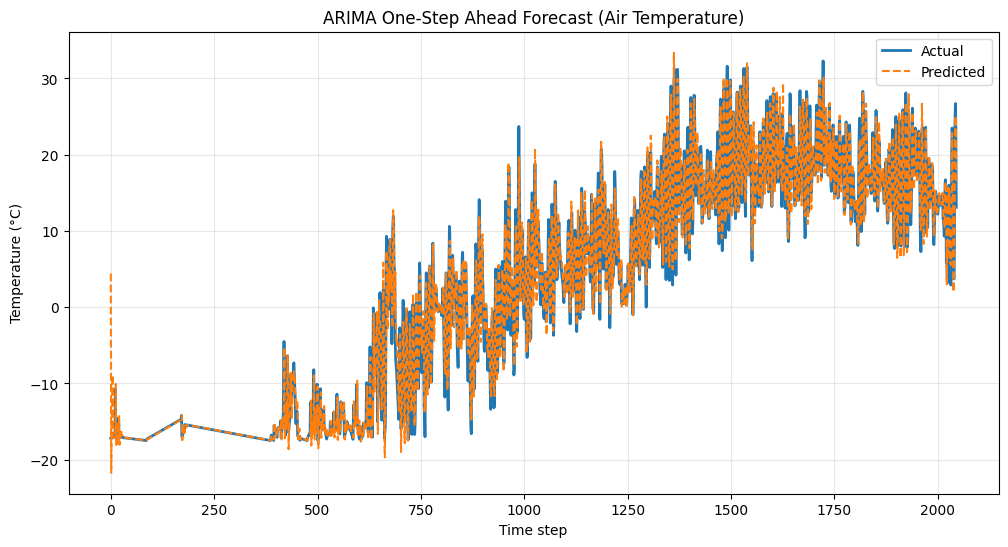

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual", linewidth=2)
plt.plot(predictions, label="Predicted", linestyle="--")
plt.title("ARIMA One-Step Ahead Forecast (Air Temperature)")
plt.xlabel("Time step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


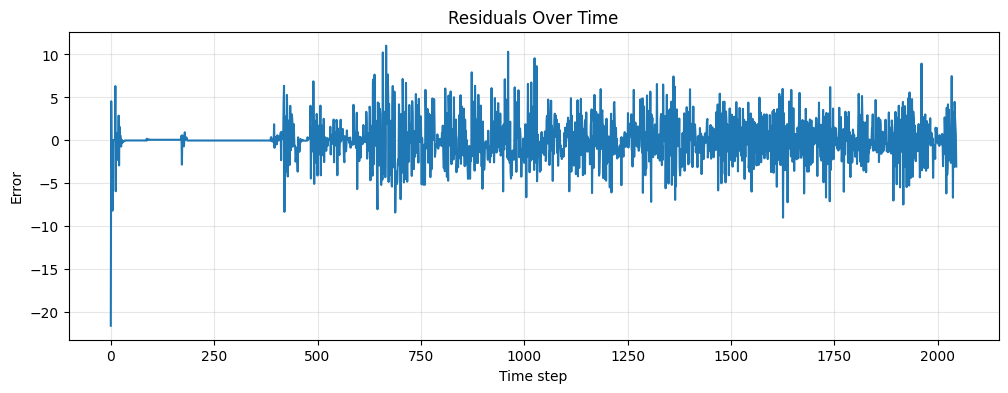

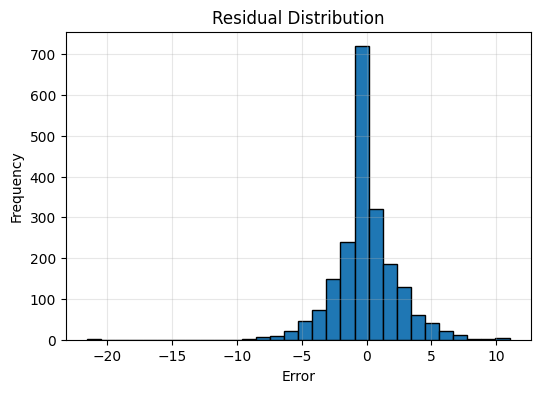

In [15]:
residuals = test - np.array(predictions)

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.xlabel("Time step")
plt.ylabel("Error")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_value, _, _, crit_vals, _ = adfuller(train)

print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Critical Values:", crit_vals)


ADF Statistic: -2.095716586873272
p-value: 0.24624046820319628
Critical Values: {'1%': np.float64(-3.4310383160337943), '5%': np.float64(-2.8618441929903073), '10%': np.float64(-2.5669319168253044)}


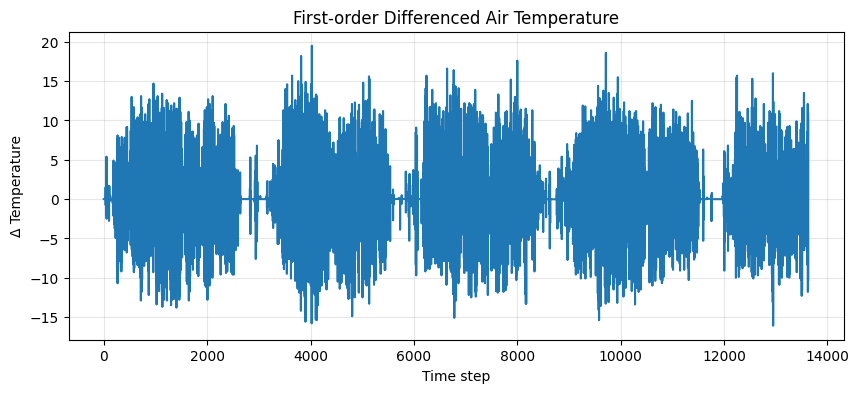

In [19]:
diff_series = np.diff(series)

plt.figure(figsize=(10,4))
plt.plot(diff_series)
plt.title("First-order Differenced Air Temperature")
plt.xlabel("Time step")
plt.ylabel("Δ Temperature")
plt.grid(alpha=0.3)
plt.show()
